In [10]:
from calendar import monthrange
from datetime import timedelta, date
from math import copysign
import numpy as np
import pandas as pd
from dateutil.easter import *
from dateutil.relativedelta import relativedelta
import datetime
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [11]:
class Scheduler(object):    
    def getSchedule(self, start, end, freq):
        delay = self.extractDelay(freq=freq)
        maturity = start + self.extractDelay(end)
        date0 = maturity
        self.datelist = [date0]
        while (date0 > start):
            date0 -= delay
            self.datelist.append(date0)
        self.datelist=sorted(self.datelist)
        return self.datelist
        
    def extractDelay(self, freq):
        freqValue=np.int(self.only_numerics(seq=freq))
        if (freq.find('M') != -1): 
            delta = relativedelta(months=+ freqValue)
        if (freq.find('Y') != -1): 
            delta = relativedelta(years=+ freqValue)
        if (freq.find('D') != -1): 
            delta = relativedelta(days=+ freqValue)
        if (freq.find('W') != -1): delta = relativedelta(days=+ 7)
        return delta
    @classmethod
    def datediff(self, date1, date2):
        if type(date1)==pd.DataFrame:
            datedifference= pd.DataFrame([x[0].days/365.0 for x in (date2.values-date1.values)] )
            return datedifference
        else:
            if type(date1)==date:
                if date1 > date2:
                    return (date1 - date2).days / 365
                return (date2 - date1).days / 365

    
    def only_numerics(self, seq):
        seq_type = type(seq)
        return seq_type().join(filter(seq_type.isdigit, seq))

In [12]:
class CDSBootstrapper(object):
    def __init__(self, CDSSpreads, r, R):
        self.myScheduler = Scheduler()
        self.data=pd.DataFrame()
        if (CDSSpreads.index[0]!="0D"):
            df = pd.DataFrame(data={"spread":0.0,
                                   "delays":relativedelta(year=0),
                                   "dates":date.today(),
                                    "yearfraction":0.0,
                                    "accrual":0.0,
                                   "Z": 1,
                                    "Q": 1}, index=["0D"])
            df = df.append(CDSSpreads)
            df.spread=df.spread*1E-4
        date1 = date.today()
        for y in df.index:
            delay= self.myScheduler.extractDelay(y)
            date2=date.today()+delay
            yearfraction = (date2-date.today()).days/365.0
            df.loc[y, "dates"] = date.today()+delay
            df.loc[y,"delays"] = delay
            df.loc[y, "accrual"] = (date2-date1).days/365.0
            df.loc[y,"yearfraction"]=yearfraction
            df.loc[y, "Z"] = np.exp(-r*yearfraction)
            date1=date2
        priorlist = [0]
        for n in range(1,len(df)):
            Zn=df.Z.iloc[n]
            Zn_1 = df.Z.iloc[n-1]
            Qn_1 = df.Q.iloc[n - 1]
            Sn=df.spread.iloc[n]
            dtn=df.accrual.iloc[n]
            priorsum=0.0
            a = 0
            for i in range(1,n):
                priorsum+=df.Z.iloc[i]*(df.Q.iloc[i]*df.spread.iloc[n]-(1.0-R)*(df.Q.iloc[i]-df.Q.iloc[i-1]))
                a = df.Z.iloc[i]*(df.Q.iloc[i]*df.spread.iloc[n]-(1.0-R)*(df.Q.iloc[i]-df.Q.iloc[i-1]))
            priorlist.append(a)
            df.Q.iloc[n]=(Zn*(1-R)*Qn_1 - priorsum)/(Zn*(dtn*Sn+1-R))
        df.loc[:,'lambda'] = priorlist
        self.data=df

In [13]:
myscheduler= Scheduler()
date1=date.today()
date2=date1+myscheduler.extractDelay("3M")
#CDSSpreads=pd.DataFrame.from_dict({"1Y":18.01,"2Y":20.98,"3Y":23.06, "4Y":31.16, "5Y":34.92}, orient="index", columns=["spread"])
#CDSSpreads=pd.DataFrame.from_dict({"1Y":52.06,"2Y":78.08,"3Y":77.89, "4Y":104.70, "5Y":119.97}, orient="index", columns=["spread"])
#CDSSpreads=pd.DataFrame.from_dict({"1Y":247.19,"2Y":237.08,"3Y":229.04, "4Y":217.03, "5Y":199.01}, orient="index", columns=["spread"])
CDSSpreads=pd.DataFrame.from_dict({"1Y":59.32,"2Y":75.13,"3Y":83.00, "4Y":105.45, "5Y":116.00}, orient="index", columns=["spread"])
myBootstrapper=CDSBootstrapper(CDSSpreads=CDSSpreads,r=0.01,R=0.5)

In [14]:
myBootstrapper.data

,Q,Z,accrual,dates,delays,spread,yearfraction,lambda
0D,1.000000,1.000000,0.00000,2018-12-17,relativedelta(),0.000000,0.00000,0.000000
1Y,0.988275,0.990050,1.00000,2019-12-17,relativedelta(years=+1),0.005932,1.00000,0.000000
2Y,0.947162,0.980172,1.00274,2020-12-17,relativedelta(years=+2),0.007513,2.00274,0.013155
3Y,0.846994,0.970419,1.00000,2021-12-17,relativedelta(years=+3),0.008300,3.00274,0.027855
4Y,0.618843,0.960763,1.00000,2022-12-17,relativedelta(years=+4),0.010545,4.00274,0.057269
5Y,0.147168,0.951203,1.00000,2023-12-17,relativedelta(years=+5),0.011600,5.00274,0.116497


In [15]:
data = myBootstrapper.data
lambdalist = data['lambda'].tolist()[1:]

In [16]:
#Monte Carlo simulation
N= 1000
T1 = 1
T2 = 2
pricelist = []
R = 0.5
K = 101

optionvalue2 = []
for j in range(N):
    optionvalue = []
    for i in range(100):
        #Finnalvalue denotes the final value of the bond and needs to be compared with the execution price.
        finnalvalue = 0
        for t in range(T1 - 1,T2):
            rand = np.random.rand()
            if(rand<np.exp(-lambdalist[t])):
                finnalvalue += 100*0.02*((1+0.05)**(T2 - t))
            else:
                #default
                finnalvalue += 100*R*((1+0.05)**(T2 - t))
                break
            if(t==T2-1):
                finnalvalue += 100
        finnalOptionValue = max(0,finnalvalue - K)
        optionvalue1 = finnalOptionValue/(1+0.05)**(T2 - T1 + 1)
        
        optionvalue.append(optionvalue1)
    optionvalue2.append(np.mean(optionvalue))

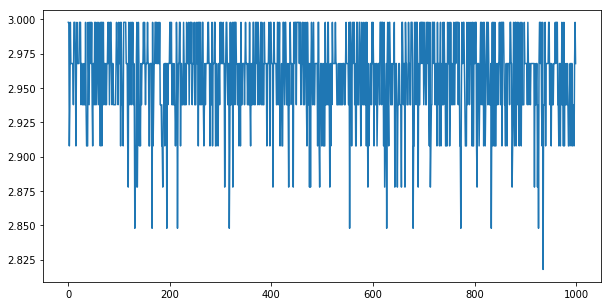

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(len(optionvalue2)),optionvalue2)

In [18]:
np.mean(optionvalue2)

2.9580424489795982